In [1]:
MONK_TASK = 1
USER = 'Paolo'

In [2]:
import sys
import os
if (colab := 'google.colab' in sys.modules):
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_PATH = '/content/drive/Shareddrives/Project_ML_23/' + USER + '/machine-learning-project'
    sys.path.insert(0,BASE_PATH)
    N_JOBS = 1
    sys.path.insert(0,BASE_PATH + '/src/utils')
    !pip install optuna
    !pip install scikit-learn
    !pip install scikeras
    TRAIN_DATA = os.path.join(BASE_PATH, 'datasets', 'monk',f'monks-{MONK_TASK}.train')
    TEST_DATA = os.path.join(BASE_PATH, 'datasets', 'monk',f'monks-{MONK_TASK}.test')
    IMAGES_FOLDER = os.path.join(BASE_PATH, 'images', 'monk',  f'task-{MONK_TASK}', 'neural_network')
    MODEL_FOLDER = os.path.join(BASE_PATH, 'trained_models', 'monk', f'task-{MONK_TASK}')
else :
    TRAIN_DATA = os.path.join('..', '..', '..', 'datasets', 'monk', f'monks-{MONK_TASK}.train')
    TEST_DATA = os.path.join('..', '..', '..', 'datasets', 'monk', f'monks-{MONK_TASK}.test')
    N_JOBS = -1
    IMAGES_FOLDER = os.path.join('..', '..', '..', 'images', 'monk', f'task-{MONK_TASK}', 'neural_network')
    MODEL_FOLDER = os.path.join('..', '..', '..', 'trained_models', 'monk', f'task-{MONK_TASK}')

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 13.0 MB/s eta 0:00:00


In [3]:
if (colab := 'google.colab' in sys.modules):
    sys.path.append(BASE_PATH + '/src/utils')
else:
    sys.path.append('../../utils')

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns; sns.set_theme(style='darkgrid')

from utils import save_plot, set_random_state
from NN import MonkNeuralNetwork

set_random_state(42)

In [4]:
# To skip the first column (row indexes)
columns_to_read = list(range(1, 8))

df_train = pd.read_csv(TRAIN_DATA, header=None, usecols=columns_to_read, delimiter=' ')
df_test = pd.read_csv(TEST_DATA, header=None, usecols=columns_to_read, delimiter=' ')
df_train.head()

1  2  3  4  5  6  7
0  1  1  1  1  1  3  1
1  1  1  1  1  1  3  2
2  1  1  1  1  3  2  1
3  1  1  1  1  3  3  2
4  1  1  1  2  1  2  1

In [5]:
features = ['feature_' + str(i) for i in range(1, 7)]

# Rename columns
new_column_names = ['class'] + features

df_train.columns = new_column_names
df_test.columns = new_column_names

df_train.head()

class  feature_1  feature_2  feature_3  feature_4  feature_5  feature_6
0      1          1          1          1          1          3          1
1      1          1          1          1          1          3          2
2      1          1          1          1          3          2          1
3      1          1          1          1          3          3          2
4      1          1          1          2          1          2          1

In [6]:
df_train_encoded = pd.get_dummies(df_train, columns=features)
df_test_encoded = pd.get_dummies(df_test, columns=features)

df_train_encoded, df_test_encoded = df_train_encoded.align(df_test_encoded, join='inner', axis=1)

df_train_encoded.head()

class  feature_1_1  feature_1_2  feature_1_3  feature_2_1  feature_2_2  \
0      1            1            0            0            1            0   
1      1            1            0            0            1            0   
2      1            1            0            0            1            0   
3      1            1            0            0            1            0   
4      1            1            0            0            1            0   

   feature_2_3  feature_3_1  feature_3_2  feature_4_1  feature_4_2  \
0            0            1            0            1            0   
1            0            1            0            1            0   
2            0            1            0            0            0   
3            0            1            0            0            0   
4            0            0            1            1            0   

   feature_4_3  feature_5_1  feature_5_2  feature_5_3  feature_5_4  \
0            0            0            0            1            0   
1            0            0            0            1            0   
2            1            0            1            0            0   
3            1            0            0            1            0   
4            0            0            1            0            0   

   feature_6_1  feature_6_2  
0            1            0  
1            0            1  
2            1            0  
3            0            1  
4            1            0

In [7]:
features = df_train_encoded.columns.difference(['class'])

X_train = df_train_encoded[features].to_numpy()
y_train = df_train_encoded['class'].to_numpy()

X_test = df_test_encoded[features].to_numpy()
y_test = df_test_encoded['class'].to_numpy()

# Create model

In [8]:
model = MonkNeuralNetwork(input_dim=X_train.shape[1], verbose=0)

In [9]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'architecture': [
        (8,), (8, 8), (8, 8, 8), (8, 8, 8, 8)
    ],
    'optimizer': ['sgd'],
    'activation': ['relu'],
    'learning_rate': [0.1, 0.3, 0.5],
    'momentum': [0.6, 0.8, 0.9],
    'lambda_value': [0.01],
    'epochs': [200],
    'batch_size': [8],
    'patience': [6]
}
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    n_jobs=N_JOBS,
    verbose=2,
    scoring='accuracy'
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 380ms/step
[CV] END activation=relu, architecture=(8,), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.6, optimizer=sgd, patience=6; total time=  12.6s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 43ms/step
[CV] END activation=relu, architecture=(8,), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.6, optimizer=sgd, patience=6; total time=  22.3s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 41ms/step
[CV] END activation=relu, architecture=(8,), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.6, optimizer=sgd, patience=6; total time=  10.8s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 41ms/step
[CV] END activation=relu, architecture=(8,), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.6, optimizer=sgd, patience=6; total time=  10.8s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 48ms/step
[CV] END activation=relu, architecture=(8,), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.6, optimizer=sgd, patience=6; total time=   4.6s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 45ms/step
[CV] END activation=relu, architecture=(8,), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.8, optimizer=sgd, patience=6; total time=   3.8s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 61ms/step
[CV] END activation=relu, architecture=(8,), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.8, optimizer=sgd, patience=6; total time=   3.1s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 50ms/step
[CV] END activation=relu, architecture=(8,), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.8, optimizer=sgd, patience=6; total time=   3.8s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 42ms/step
[CV] END activation=relu, architecture=(8,), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.8, optimizer=sgd, patience=6; total time=   2.4s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 43ms/step
[CV] END activation=relu, architecture=(8,), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.8, optimizer=sgd, patience=6; total time=   5.7s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 57ms/step
[CV] END activation=relu, architecture=(8,), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.9, optimizer=sgd, patience=6; total time=   2.4s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 65ms/step
[CV] END activation=relu, architecture=(8,), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.9, optimizer=sgd, patience=6; total time=   1.6s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 44ms/step
[CV] END activation=relu, architecture=(8,), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.9, optimizer=sgd, patience=6; total time=   2.3s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 43ms/step
[CV] END activation=relu, architecture=(8,), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.9, optimizer=sgd, patience=6; total time=   3.1s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 43ms/step
[CV] END activation=relu, architecture=(8,), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.9, optimizer=sgd, patience=6; total time=   2.2s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 41ms/step
[CV] END activation=relu, architecture=(8,), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.6, optimizer=sgd, patience=6; total time=   3.1s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 59ms/step
[CV] END activation=relu, architecture=(8,), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.6, optimizer=sgd, patience=6; total time=   3.1s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 66ms/step
[CV] END activation=relu, architecture=(8,), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.6, optimizer=sgd, patience=6; total time=   2.6s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 42ms/step
[CV] END activation=relu, architecture=(8,), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.6, optimizer=sgd, patience=6; total time=   2.5s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 43ms/step
[CV] END activation=relu, architecture=(8,), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.6, optimizer=sgd, patience=6; total time=   2.6s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 41ms/step
[CV] END activation=relu, architecture=(8,), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.8, optimizer=sgd, patience=6; total time=   1.7s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 41ms/step
[CV] END activation=relu, architecture=(8,), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.8, optimizer=sgd, patience=6; total time=   1.9s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 61ms/step
[CV] END activation=relu, architecture=(8,), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.8, optimizer=sgd, patience=6; total time=   1.9s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 68ms/step
[CV] END activation=relu, architecture=(8,), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.8, optimizer=sgd, patience=6; total time=   1.7s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 42ms/step
[CV] END activation=relu, architecture=(8,), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.8, optimizer=sgd, patience=6; total time=   3.3s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 41ms/step
[CV] END activation=relu, architecture=(8,), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.9, optimizer=sgd, patience=6; total time=   0.9s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 41ms/step
[CV] END activation=relu, architecture=(8,), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.9, optimizer=sgd, patience=6; total time=   1.2s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 40ms/step
[CV] END activation=relu, architecture=(8,), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.9, optimizer=sgd, patience=6; total time=   1.2s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 49ms/step
[CV] END activation=relu, architecture=(8,), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.9, optimizer=sgd, patience=6; total time=   1.1s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 46ms/step
[CV] END activation=relu, architecture=(8,), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.9, optimizer=sgd, patience=6; total time=   1.2s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 43ms/step
[CV] END activation=relu, architecture=(8,), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.6, optimizer=sgd, patience=6; total time=   1.8s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 43ms/step
[CV] END activation=relu, architecture=(8,), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.6, optimizer=sgd, patience=6; total time=   1.8s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 65ms/step
[CV] END activation=relu, architecture=(8,), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.6, optimizer=sgd, patience=6; total time=   2.0s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 41ms/step
[CV] END activation=relu, architecture=(8,), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.6, optimizer=sgd, patience=6; total time=   3.3s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 41ms/step
[CV] END activation=relu, architecture=(8,), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.6, optimizer=sgd, patience=6; total time=   2.4s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 45ms/step
[CV] END activation=relu, architecture=(8,), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.8, optimizer=sgd, patience=6; total time=   1.0s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 42ms/step
[CV] END activation=relu, architecture=(8,), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.8, optimizer=sgd, patience=6; total time=   1.2s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 45ms/step
[CV] END activation=relu, architecture=(8,), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.8, optimizer=sgd, patience=6; total time=   1.2s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 45ms/step
[CV] END activation=relu, architecture=(8,), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.8, optimizer=sgd, patience=6; total time=   1.2s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 43ms/step
[CV] END activation=relu, architecture=(8,), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.8, optimizer=sgd, patience=6; total time=   1.8s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 59ms/step
[CV] END activation=relu, architecture=(8,), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.9, optimizer=sgd, patience=6; total time=   1.2s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 63ms/step
[CV] END activation=relu, architecture=(8,), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.9, optimizer=sgd, patience=6; total time=   1.7s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 60ms/step
[CV] END activation=relu, architecture=(8,), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.9, optimizer=sgd, patience=6; total time=   1.3s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 1s 546ms/step
[CV] END activation=relu, architecture=(8,), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.9, optimizer=sgd, patience=6; total time=   1.9s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 43ms/step
[CV] END activation=relu, architecture=(8,), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.9, optimizer=sgd, patience=6; total time=   1.9s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 50ms/step
[CV] END activation=relu, architecture=(8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.6, optimizer=sgd, patience=6; total time=   5.8s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 70ms/step
[CV] END activation=relu, architecture=(8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.6, optimizer=sgd, patience=6; total time=   9.0s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 53ms/step
[CV] END activation=relu, architecture=(8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.6, optimizer=sgd, patience=6; total time=   5.9s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 73ms/step
[CV] END activation=relu, architecture=(8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.6, optimizer=sgd, patience=6; total time=   7.3s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 49ms/step
[CV] END activation=relu, architecture=(8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.6, optimizer=sgd, patience=6; total time=   6.1s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 54ms/step
[CV] END activation=relu, architecture=(8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.8, optimizer=sgd, patience=6; total time=   1.9s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 49ms/step
[CV] END activation=relu, architecture=(8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.8, optimizer=sgd, patience=6; total time=   2.3s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 70ms/step
[CV] END activation=relu, architecture=(8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.8, optimizer=sgd, patience=6; total time=   3.2s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 48ms/step
[CV] END activation=relu, architecture=(8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.8, optimizer=sgd, patience=6; total time=   5.9s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 46ms/step
[CV] END activation=relu, architecture=(8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.8, optimizer=sgd, patience=6; total time=   5.7s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 72ms/step
[CV] END activation=relu, architecture=(8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.9, optimizer=sgd, patience=6; total time=   1.9s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 69ms/step
[CV] END activation=relu, architecture=(8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.9, optimizer=sgd, patience=6; total time=   2.1s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 49ms/step
[CV] END activation=relu, architecture=(8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.9, optimizer=sgd, patience=6; total time=   3.1s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 50ms/step
[CV] END activation=relu, architecture=(8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.9, optimizer=sgd, patience=6; total time=   1.9s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 49ms/step
[CV] END activation=relu, architecture=(8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.9, optimizer=sgd, patience=6; total time=   2.0s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 48ms/step
[CV] END activation=relu, architecture=(8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.6, optimizer=sgd, patience=6; total time=   1.4s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 48ms/step
[CV] END activation=relu, architecture=(8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.6, optimizer=sgd, patience=6; total time=   2.1s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 47ms/step
[CV] END activation=relu, architecture=(8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.6, optimizer=sgd, patience=6; total time=   2.0s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 72ms/step
[CV] END activation=relu, architecture=(8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.6, optimizer=sgd, patience=6; total time=   3.4s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 49ms/step
[CV] END activation=relu, architecture=(8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.6, optimizer=sgd, patience=6; total time=   2.9s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 48ms/step
[CV] END activation=relu, architecture=(8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.8, optimizer=sgd, patience=6; total time=   1.9s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 48ms/step
[CV] END activation=relu, architecture=(8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.8, optimizer=sgd, patience=6; total time=   1.2s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 50ms/step
[CV] END activation=relu, architecture=(8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.8, optimizer=sgd, patience=6; total time=   1.6s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 51ms/step
[CV] END activation=relu, architecture=(8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.8, optimizer=sgd, patience=6; total time=   1.9s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 48ms/step
[CV] END activation=relu, architecture=(8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.8, optimizer=sgd, patience=6; total time=   1.9s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 72ms/step
[CV] END activation=relu, architecture=(8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.9, optimizer=sgd, patience=6; total time=   1.4s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 76ms/step
[CV] END activation=relu, architecture=(8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.9, optimizer=sgd, patience=6; total time=   2.9s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 49ms/step
[CV] END activation=relu, architecture=(8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.9, optimizer=sgd, patience=6; total time=   1.5s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 50ms/step
[CV] END activation=relu, architecture=(8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.9, optimizer=sgd, patience=6; total time=   1.3s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 61ms/step
[CV] END activation=relu, architecture=(8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.9, optimizer=sgd, patience=6; total time=   1.7s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 58ms/step
[CV] END activation=relu, architecture=(8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.6, optimizer=sgd, patience=6; total time=   1.8s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 54ms/step
[CV] END activation=relu, architecture=(8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.6, optimizer=sgd, patience=6; total time=   2.0s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 51ms/step
[CV] END activation=relu, architecture=(8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.6, optimizer=sgd, patience=6; total time=   2.0s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 70ms/step
[CV] END activation=relu, architecture=(8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.6, optimizer=sgd, patience=6; total time=   2.7s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 71ms/step
[CV] END activation=relu, architecture=(8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.6, optimizer=sgd, patience=6; total time=   2.1s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 61ms/step
[CV] END activation=relu, architecture=(8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.8, optimizer=sgd, patience=6; total time=   1.4s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 49ms/step
[CV] END activation=relu, architecture=(8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.8, optimizer=sgd, patience=6; total time=   1.3s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 48ms/step
[CV] END activation=relu, architecture=(8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.8, optimizer=sgd, patience=6; total time=   1.2s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 55ms/step
[CV] END activation=relu, architecture=(8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.8, optimizer=sgd, patience=6; total time=   1.3s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 51ms/step
[CV] END activation=relu, architecture=(8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.8, optimizer=sgd, patience=6; total time=   1.3s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 58ms/step
[CV] END activation=relu, architecture=(8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.9, optimizer=sgd, patience=6; total time=   1.1s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 52ms/step
[CV] END activation=relu, architecture=(8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.9, optimizer=sgd, patience=6; total time=   1.3s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 48ms/step
[CV] END activation=relu, architecture=(8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.9, optimizer=sgd, patience=6; total time=   1.9s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 69ms/step
[CV] END activation=relu, architecture=(8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.9, optimizer=sgd, patience=6; total time=   1.7s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 72ms/step
[CV] END activation=relu, architecture=(8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.9, optimizer=sgd, patience=6; total time=   2.2s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 52ms/step
[CV] END activation=relu, architecture=(8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.6, optimizer=sgd, patience=6; total time=   4.8s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 54ms/step
[CV] END activation=relu, architecture=(8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.6, optimizer=sgd, patience=6; total time=   4.2s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 86ms/step
[CV] END activation=relu, architecture=(8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.6, optimizer=sgd, patience=6; total time=   5.3s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 57ms/step
[CV] END activation=relu, architecture=(8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.6, optimizer=sgd, patience=6; total time=   4.9s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 53ms/step
[CV] END activation=relu, architecture=(8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.6, optimizer=sgd, patience=6; total time=   6.8s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 81ms/step
[CV] END activation=relu, architecture=(8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.8, optimizer=sgd, patience=6; total time=   3.3s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 84ms/step
[CV] END activation=relu, architecture=(8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.8, optimizer=sgd, patience=6; total time=   3.3s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 86ms/step
[CV] END activation=relu, architecture=(8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.8, optimizer=sgd, patience=6; total time=   3.3s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 54ms/step
[CV] END activation=relu, architecture=(8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.8, optimizer=sgd, patience=6; total time=   2.3s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 81ms/step
[CV] END activation=relu, architecture=(8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.8, optimizer=sgd, patience=6; total time=   5.9s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 71ms/step
[CV] END activation=relu, architecture=(8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.9, optimizer=sgd, patience=6; total time=   4.3s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 66ms/step
[CV] END activation=relu, architecture=(8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.9, optimizer=sgd, patience=6; total time=   2.0s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 56ms/step
[CV] END activation=relu, architecture=(8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.9, optimizer=sgd, patience=6; total time=   3.3s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 63ms/step
[CV] END activation=relu, architecture=(8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.9, optimizer=sgd, patience=6; total time=   2.0s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 86ms/step
[CV] END activation=relu, architecture=(8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.9, optimizer=sgd, patience=6; total time=   3.3s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 57ms/step
[CV] END activation=relu, architecture=(8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.6, optimizer=sgd, patience=6; total time=   2.2s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 57ms/step
[CV] END activation=relu, architecture=(8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.6, optimizer=sgd, patience=6; total time=   1.6s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 65ms/step
[CV] END activation=relu, architecture=(8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.6, optimizer=sgd, patience=6; total time=   2.0s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 67ms/step
[CV] END activation=relu, architecture=(8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.6, optimizer=sgd, patience=6; total time=   2.0s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 54ms/step
[CV] END activation=relu, architecture=(8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.6, optimizer=sgd, patience=6; total time=   3.3s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 83ms/step
[CV] END activation=relu, architecture=(8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.8, optimizer=sgd, patience=6; total time=   3.3s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 103ms/step
[CV] END activation=relu, architecture=(8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.8, optimizer=sgd, patience=6; total time=   2.4s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 82ms/step
[CV] END activation=relu, architecture=(8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.8, optimizer=sgd, patience=6; total time=   3.5s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 53ms/step
[CV] END activation=relu, architecture=(8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.8, optimizer=sgd, patience=6; total time=   1.9s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 57ms/step
[CV] END activation=relu, architecture=(8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.8, optimizer=sgd, patience=6; total time=   3.3s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 55ms/step
[CV] END activation=relu, architecture=(8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.9, optimizer=sgd, patience=6; total time=   1.2s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 55ms/step
[CV] END activation=relu, architecture=(8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.9, optimizer=sgd, patience=6; total time=   1.4s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 57ms/step
[CV] END activation=relu, architecture=(8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.9, optimizer=sgd, patience=6; total time=   1.3s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 90ms/step
[CV] END activation=relu, architecture=(8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.9, optimizer=sgd, patience=6; total time=   2.2s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 82ms/step
[CV] END activation=relu, architecture=(8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.9, optimizer=sgd, patience=6; total time=   2.2s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 54ms/step
[CV] END activation=relu, architecture=(8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.6, optimizer=sgd, patience=6; total time=   1.6s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 59ms/step
[CV] END activation=relu, architecture=(8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.6, optimizer=sgd, patience=6; total time=   1.4s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 55ms/step
[CV] END activation=relu, architecture=(8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.6, optimizer=sgd, patience=6; total time=   2.0s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 53ms/step
[CV] END activation=relu, architecture=(8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.6, optimizer=sgd, patience=6; total time=   2.0s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 58ms/step
[CV] END activation=relu, architecture=(8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.6, optimizer=sgd, patience=6; total time=   2.0s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 82ms/step
[CV] END activation=relu, architecture=(8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.8, optimizer=sgd, patience=6; total time=   2.0s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 77ms/step
[CV] END activation=relu, architecture=(8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.8, optimizer=sgd, patience=6; total time=   2.1s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 78ms/step
[CV] END activation=relu, architecture=(8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.8, optimizer=sgd, patience=6; total time=   2.3s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 59ms/step
[CV] END activation=relu, architecture=(8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.8, optimizer=sgd, patience=6; total time=   2.2s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 56ms/step
[CV] END activation=relu, architecture=(8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.8, optimizer=sgd, patience=6; total time=   2.0s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 56ms/step
[CV] END activation=relu, architecture=(8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.9, optimizer=sgd, patience=6; total time=   1.5s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 54ms/step
[CV] END activation=relu, architecture=(8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.9, optimizer=sgd, patience=6; total time=   1.4s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 1s 801ms/step
[CV] END activation=relu, architecture=(8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.9, optimizer=sgd, patience=6; total time=   2.8s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 93ms/step
[CV] END activation=relu, architecture=(8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.9, optimizer=sgd, patience=6; total time=   1.7s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 92ms/step
[CV] END activation=relu, architecture=(8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.9, optimizer=sgd, patience=6; total time=   2.1s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 63ms/step
[CV] END activation=relu, architecture=(8, 8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.6, optimizer=sgd, patience=6; total time=   7.5s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 61ms/step
[CV] END activation=relu, architecture=(8, 8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.6, optimizer=sgd, patience=6; total time=   5.9s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 87ms/step
[CV] END activation=relu, architecture=(8, 8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.6, optimizer=sgd, patience=6; total time=   4.9s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 62ms/step
[CV] END activation=relu, architecture=(8, 8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.6, optimizer=sgd, patience=6; total time=   3.6s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 59ms/step
[CV] END activation=relu, architecture=(8, 8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.6, optimizer=sgd, patience=6; total time=   3.8s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 65ms/step
[CV] END activation=relu, architecture=(8, 8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.8, optimizer=sgd, patience=6; total time=   2.7s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 86ms/step
[CV] END activation=relu, architecture=(8, 8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.8, optimizer=sgd, patience=6; total time=   3.4s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 94ms/step
[CV] END activation=relu, architecture=(8, 8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.8, optimizer=sgd, patience=6; total time=   3.0s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 59ms/step
[CV] END activation=relu, architecture=(8, 8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.8, optimizer=sgd, patience=6; total time=   3.4s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 60ms/step
[CV] END activation=relu, architecture=(8, 8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.8, optimizer=sgd, patience=6; total time=   3.4s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 60ms/step
[CV] END activation=relu, architecture=(8, 8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.9, optimizer=sgd, patience=6; total time=   2.1s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 92ms/step
[CV] END activation=relu, architecture=(8, 8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.9, optimizer=sgd, patience=6; total time=   1.6s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 93ms/step
[CV] END activation=relu, architecture=(8, 8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.9, optimizer=sgd, patience=6; total time=   2.5s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 87ms/step
[CV] END activation=relu, architecture=(8, 8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.9, optimizer=sgd, patience=6; total time=   2.4s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 65ms/step
[CV] END activation=relu, architecture=(8, 8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.1, momentum=0.9, optimizer=sgd, patience=6; total time=   2.0s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 63ms/step
[CV] END activation=relu, architecture=(8, 8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.6, optimizer=sgd, patience=6; total time=   3.4s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 58ms/step
[CV] END activation=relu, architecture=(8, 8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.6, optimizer=sgd, patience=6; total time=   2.4s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 61ms/step
[CV] END activation=relu, architecture=(8, 8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.6, optimizer=sgd, patience=6; total time=   2.2s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 86ms/step
[CV] END activation=relu, architecture=(8, 8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.6, optimizer=sgd, patience=6; total time=   3.4s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 68ms/step
[CV] END activation=relu, architecture=(8, 8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.6, optimizer=sgd, patience=6; total time=   3.6s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 58ms/step
[CV] END activation=relu, architecture=(8, 8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.8, optimizer=sgd, patience=6; total time=   3.3s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 66ms/step
[CV] END activation=relu, architecture=(8, 8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.8, optimizer=sgd, patience=6; total time=   1.7s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 73ms/step
[CV] END activation=relu, architecture=(8, 8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.8, optimizer=sgd, patience=6; total time=   2.1s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 70ms/step
[CV] END activation=relu, architecture=(8, 8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.8, optimizer=sgd, patience=6; total time=   1.7s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 86ms/step
[CV] END activation=relu, architecture=(8, 8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.8, optimizer=sgd, patience=6; total time=   1.7s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 92ms/step
[CV] END activation=relu, architecture=(8, 8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.9, optimizer=sgd, patience=6; total time=   1.9s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 88ms/step
[CV] END activation=relu, architecture=(8, 8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.9, optimizer=sgd, patience=6; total time=   2.3s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 63ms/step
[CV] END activation=relu, architecture=(8, 8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.9, optimizer=sgd, patience=6; total time=   2.3s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 58ms/step
[CV] END activation=relu, architecture=(8, 8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.9, optimizer=sgd, patience=6; total time=   2.1s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 60ms/step
[CV] END activation=relu, architecture=(8, 8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.3, momentum=0.9, optimizer=sgd, patience=6; total time=   2.1s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 58ms/step
[CV] END activation=relu, architecture=(8, 8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.6, optimizer=sgd, patience=6; total time=   3.4s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 105ms/step
[CV] END activation=relu, architecture=(8, 8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.6, optimizer=sgd, patience=6; total time=   3.1s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 108ms/step
[CV] END activation=relu, architecture=(8, 8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.6, optimizer=sgd, patience=6; total time=   2.3s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 66ms/step
[CV] END activation=relu, architecture=(8, 8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.6, optimizer=sgd, patience=6; total time=   2.3s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 63ms/step
[CV] END activation=relu, architecture=(8, 8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.6, optimizer=sgd, patience=6; total time=   2.1s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 62ms/step
[CV] END activation=relu, architecture=(8, 8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.8, optimizer=sgd, patience=6; total time=   2.1s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 62ms/step
[CV] END activation=relu, architecture=(8, 8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.8, optimizer=sgd, patience=6; total time=   2.1s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 62ms/step
[CV] END activation=relu, architecture=(8, 8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.8, optimizer=sgd, patience=6; total time=   2.1s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 94ms/step
[CV] END activation=relu, architecture=(8, 8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.8, optimizer=sgd, patience=6; total time=   2.2s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 88ms/step
[CV] END activation=relu, architecture=(8, 8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.8, optimizer=sgd, patience=6; total time=   2.4s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 67ms/step
[CV] END activation=relu, architecture=(8, 8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.9, optimizer=sgd, patience=6; total time=   2.3s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 61ms/step
[CV] END activation=relu, architecture=(8, 8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.9, optimizer=sgd, patience=6; total time=   2.1s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 60ms/step
[CV] END activation=relu, architecture=(8, 8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.9, optimizer=sgd, patience=6; total time=   2.1s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 64ms/step
[CV] END activation=relu, architecture=(8, 8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.9, optimizer=sgd, patience=6; total time=   1.7s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 61ms/step
[CV] END activation=relu, architecture=(8, 8, 8, 8), batch_size=8, epochs=200, lambda_value=0.01, learning_rate=0.5, momentum=0.9, optimizer=sgd, patience=6; total time=   1.8s


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

GridSearchCV(cv=5, estimator=MonkNeuralNetwork(verbose=0), n_jobs=1,
             param_grid={'activation': ['relu'],
                         'architecture': [(8,), (8, 8), (8, 8, 8),
                                          (8, 8, 8, 8)],
                         'batch_size': [8], 'epochs': [200],
                         'lambda_value': [0.01],
                         'learning_rate': [0.1, 0.3, 0.5],
                         'momentum': [0.6, 0.8, 0.9], 'optimizer': ['sgd'],
                         'patience': [6]},
             scoring='accuracy', verbose=2)

In [10]:
results = grid_search.cv_results_

# Converti i risultati in un DataFrame per una migliore visualizzazione
results_df = pd.DataFrame(results)
csv_filename = f'Monk_NN_{MONK_TASK}.csv'
results_df.to_csv(csv_filename, index=False)

In [11]:
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)
train_scores, test_scores = [], []

best_params = grid_search.best_params_

# Cross-validation con i migliori parametri
for train_index, test_index in cv.split(X_train):
    X_train_1, X_test_1 = X_train[train_index], X_train[test_index]
    y_train_1, y_test_1 = y_train[train_index], y_train[test_index]

    best_model = MonkNeuralNetwork(input_dim=X_train_1.shape[1], verbose=0, **best_params)
    best_model.fit(X_train_1, y_train_1, validation_data=(X_test_1, y_test_1))

    #df = best_model.history.history
    train_scores.append(best_model.history.history)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [12]:
train_scores_df = pd.DataFrame(train_scores)

In [13]:
# TODO :
# plottare risultati di ogni fold, plottando la media(o il best) dei fold e la varianza per ogni fold
# hold out test set, usarlo per il model assestment
# alla fine fare retrain di tutto compreso hold out test set prima di fare predict sui risultati di micheli

In [14]:
train_scores_df['val_loss']

0    [0.44117724895477295, 0.40763619542121887, 0.3...
1    [0.3854949176311493, 0.3551088273525238, 0.332...
2    [0.4194585382938385, 0.4008598327636719, 0.370...
3    [0.4445430338382721, 0.41523751616477966, 0.37...
4    [0.4315269887447357, 0.4054816663265228, 0.385...
Name: val_loss, dtype: object

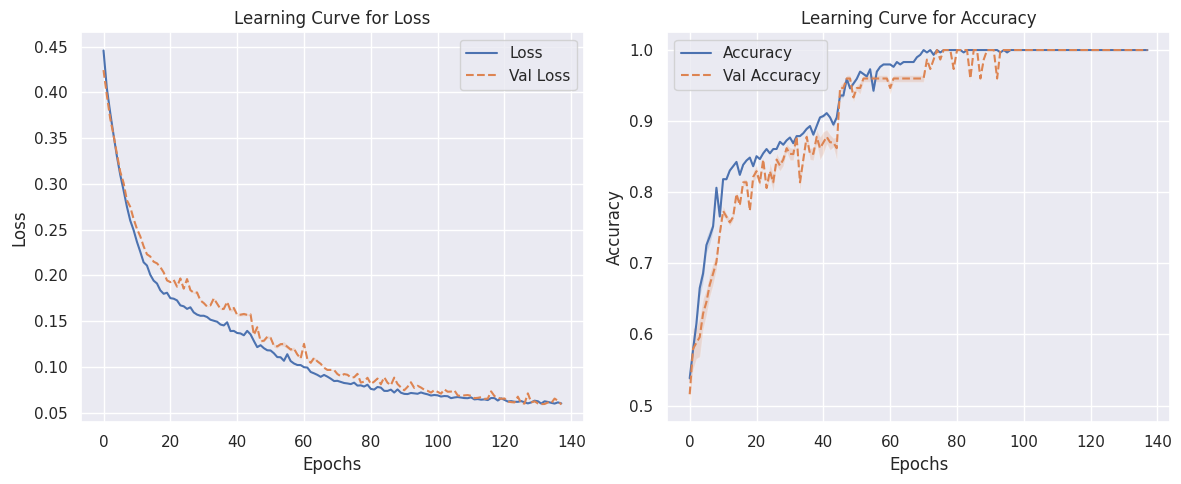

In [22]:
loss, val_loss, acc, val_acc = [], [], [], []

for i in range(len(train_scores_df)):
    loss.append(train_scores_df.iloc[i]['loss'])
    val_loss.append(train_scores_df.iloc[i]['val_loss'])
    acc.append(train_scores_df.iloc[i]['binary_accuracy'])
    val_acc.append(train_scores_df.iloc[i]['val_binary_accuracy'])

df_loss = pd.DataFrame(loss).T
df_val_loss = pd.DataFrame(val_loss).T
df_acc = pd.DataFrame(acc).T
df_val_acc = pd.DataFrame(val_acc).T

mean_loss = df_loss.mean(axis=1)
var_loss = df_loss.var(axis=1)
mean_val_loss = df_val_loss.mean(axis=1)
var_val_loss = df_val_loss.var(axis=1)

mean_acc = df_acc.mean(axis=1)
var_acc = df_acc.var(axis=1)
mean_val_acc = df_val_acc.mean(axis=1)
var_val_acc = df_val_acc.var(axis=1)

plt.figure(figsize=(12, 5))

# loss and val_loss
plt.subplot(1, 2, 1)
plt.plot(mean_loss, label='Loss', linestyle='-')
plt.fill_between(range(len(mean_loss)), mean_loss-var_loss, mean_loss+var_loss, alpha=0.2)
plt.plot(mean_val_loss, label='Val Loss', linestyle='--')
plt.fill_between(range(len(mean_val_loss)), mean_val_loss-var_val_loss, mean_val_loss+var_val_loss, alpha=0.2)
plt.title('Learning Curve for Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# binary_accuracy and val_binary_accuracy
plt.subplot(1, 2, 2)
plt.plot(mean_acc, label='Accuracy', linestyle='-')
plt.fill_between(range(len(mean_acc)), mean_acc-var_acc, mean_acc+var_acc, alpha=0.2)
plt.plot(mean_val_acc, label='Val Accuracy', linestyle='--')
plt.fill_between(range(len(mean_val_acc)), mean_val_acc-var_val_acc, mean_val_acc+var_val_acc, alpha=0.2)
plt.title('Learning Curve for Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
# Create dataframes for train_scores and test_scores
train_scores_filename = f"Monk_NN_{MONK_TASK}_train_scores.csv"

# Save dataframes to CSV files
train_scores_df.to_csv(train_scores_filename, index=False)

In [17]:
final_model = grid_search.best_estimator_

In [18]:
final_model.history.history

{'loss': [0.43898677825927734,
  0.4005284607410431,
  0.3707979917526245,
  0.341830849647522,
  0.3143320679664612,
  0.28879600763320923,
  0.26777833700180054,
  0.2487177550792694,
  0.23223361372947693,
  0.2180580198764801,
  0.20838505029678345,
  0.2011234164237976,
  0.19595967233181,
  0.19185076653957367,
  0.18566596508026123,
  0.1761862337589264,
  0.17591334879398346,
  0.17136354744434357,
  0.1709940880537033,
  0.1694842129945755,
  0.17148971557617188,
  0.1628313809633255,
  0.1628316044807434,
  0.15812398493289948,
  0.16118110716342926,
  0.1538826823234558,
  0.1551508903503418,
  0.15215396881103516,
  0.15467706322669983,
  0.1520516574382782,
  0.15006637573242188,
  0.14367550611495972,
  0.14191734790802002,
  0.13878241181373596,
  0.13077270984649658,
  0.13306795060634613,
  0.12791724503040314,
  0.12711794674396515,
  0.1222022995352745,
  0.1089300736784935,
  0.10543955862522125,
  0.11131599545478821,
  0.10114440321922302,
  0.10740675032138824,
 

In [19]:
from sklearn.metrics import accuracy_score, classification_report

# Test set accuracy hold-out

final_model = grid_search.best_estimator_
y_pred = final_model.predict(X_test)

print('Best parameters: ', grid_search.best_params_)
print('Best accuracy: ', grid_search.best_score_)
print('Test set accuracy: ', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

14/14 [==============================] - 0s 2ms/step
Best parameters:  {'activation': 'relu', 'architecture': (8, 8), 'batch_size': 8, 'epochs': 200, 'lambda_value': 0.01, 'learning_rate': 0.1, 'momentum': 0.6, 'optimizer': 'sgd', 'patience': 6}
Best accuracy:  0.8363333333333334
Test set accuracy:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       216
           1       1.00      1.00      1.00       216

    accuracy                           1.00       432
   macro avg       1.00      1.00      1.00       432
weighted avg       1.00      1.00      1.00       432



# Learning curve

In [20]:
train_scores_df[['loss', 'val_loss']].plot(
    figsize=(8, 5),
    xlim=[0, 200],
    ylim=[0, 2],
    grid=True,
    xlabel='Epoch',
    style=['r--', 'b--'],
    title='Training and Validation Loss'
)
plt.show()

TypeError: no numeric data to plot

In [ ]:
history_df[['accuracy', 'val_accuracy']].plot(
    figsize=(8, 5),
    xlim=[0, 200],
    ylim=[0, 1],
    grid=True,
    xlabel='Epoch',
    style=['r--.', 'b--'],
    title='Training and Validation Accuracy'
)
plt.show()

# Save model

In [ ]:
from joblib import dump

model_path = os.path.join(MODEL_FOLDER, 'NN_model.joblib')
dump(final_model, model_path, compress=3)